In [427]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import pystan_utils
from imblearn.datasets import make_imbalance ## for resampling 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

### Dataset
The dataset consists of survey data collected on the trains between St. Gallen and Geneva, Switzerland, during March 1998. The respondents provided information in order to analyze the impact of the modal innovation in transportation, represented by the Swissmetro. For more information about the data set and the process of data collection please see: 

Antonini, G., Gioia, C., & Frejinger, E. (2007). Swissmetro: description of the data.

In [294]:
df = pd.read_csv("Swiss_data.csv")
print("No. of rows = %d, No. of columns = %d" % df.shape)
df.head()

No. of rows = 10710, No. of columns = 16


,ID,PURPOSE,AGE,GENDER,INCOME,GA,AV.TRAIN,AV.SM,AV.CAR,TT.TRAIN,TT.SM,TT.CAR,CO.TRAIN,CO.SM,CO.CAR,CHOICE
0,1,1,3,0,2,0,1,1,1,1.12,0.63,1.17,0.48,0.52,0.65,SM
1,1,1,3,0,2,0,1,1,1,1.03,0.60,1.17,0.48,0.49,0.84,SM
2,1,1,3,0,2,0,1,1,1,1.30,0.67,1.17,0.48,0.58,0.52,SM
3,1,1,3,0,2,0,1,1,1,1.03,0.63,0.72,0.40,0.52,0.52,SM
4,1,1,3,0,2,0,1,1,1,1.30,0.63,0.90,0.36,0.42,0.84,SM


In [295]:
## inspecting missing values
print(df.isnull().sum())
## inspecting data types
df.dtypes

ID          0
PURPOSE     0
AGE         0
GENDER      0
INCOME      0
GA          0
AV.TRAIN    0
AV.SM       0
AV.CAR      0
TT.TRAIN    0
TT.SM       0
TT.CAR      0
CO.TRAIN    0
CO.SM       0
CO.CAR      0
CHOICE      0
dtype: int64


ID            int64
PURPOSE       int64
AGE           int64
GENDER        int64
INCOME        int64
GA            int64
AV.TRAIN      int64
AV.SM         int64
AV.CAR        int64
TT.TRAIN    float64
TT.SM       float64
TT.CAR      float64
CO.TRAIN    float64
CO.SM       float64
CO.CAR      float64
CHOICE       object
dtype: object

![title](table.png)

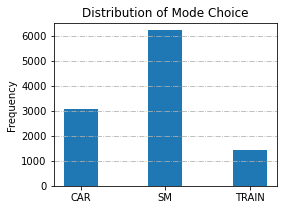

In [296]:
no_class = df.CHOICE.value_counts().sort_index().values.tolist()
label = df.CHOICE.value_counts().sort_index().index.tolist()
def plot_bar_x():
    plt.figure(figsize=(4,3))
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_class,width=.4)
    #plt.xlabel('Travel mode')
    plt.ylabel('Frequency')
    plt.xticks(index, label, rotation=0)
    plt.grid(linestyle="-.",axis="y")
    plt.title('Distribution of Mode Choice')
    plt.show()

plot_bar_x()

Preprocess data:

In [297]:
## Conevert CHOICE column into integer
def string_to_int(item):
    if item == "TRAIN": item = 1
    elif item == "SM": item = 2
    elif item == "CAR" : item = 3
    return(item)

df["CHOICE"] = df["CHOICE"].apply(lambda x: string_to_int(x))

In [298]:
## get dummy variables
def get_dummy (col_name):
    if col_name in df.columns:
        uniq = df[col_name].unique()
        col_names=[col_name+str(i+1) for i in range(len(uniq))]
        dummy_col = pd.get_dummies(df[col_name]).set_axis(col_names,axis=1)
        return dummy_col
    else:
        print("Column is not in the dataframe")

In [299]:
Cols = ["PURPOSE","AGE","INCOME"]
for col in Cols:
    df = pd.concat([df,get_dummy(col)],axis =1)
    ## remove duplicated columns
    df = df.loc[:,~df.columns.duplicated()]
## remove "PURPOSE", "AGE" and "INCOME" from the dataset
new_df = df.drop(Cols,axis=1)

In [321]:
# separate between features/inputs (X) and target/output variables (y)
X = new_df.drop(["ID","CHOICE"],axis=1).values
print(X.shape)
y = new_df["CHOICE"].values.astype("int")
print(y.shape)
ind = new_df["ID"].values.astype("int")
print(ind.shape)

(10710, 25)
(10710,)
(10710,)


1192

Train/test split:

In [302]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 7068
num test: 3642


#### Oversample minority class:
Always split into test and train sets BEFORE trying oversampling techniques! 

In [390]:
X0= ind_train.reshape(-1,1)
## add ind_train to X_train
XX = np.c_[X0,X_train]

# Undersampling
d = {}
for x in y_train:
    d[x] = d.get(x,0)+1
d

{1: 947, 2: 4101, 3: 2020}

In [389]:
XX_rs, y_rs = make_imbalance(XX, y_train, sampling_strategy={1: 947, 2: 1200, 3:1200}, random_state=0)
X_rs = XX_rs[:,1:]
ind_rs = XX_rs[:,0]

### Plate notation

![title](PGM_HR.png)

### Hierarchical logistic regression in STAN

We will now implement a hierarchical logistic regression. The motivation is actually quite simple. Our dataset consists of multiple observations from various individuals. However, when we build our original logistic regression in STAN, our specification assumes that all individuals share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all individuals are equally biased towards a given mode (e.g. car). This is obviously a very strong assumption, right? We should allow different individuals to have different biases (alpha). (We could also consider different coefficients per individual, but for the sake of simplicy, we will just focus on the bias parameters)

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global intercept mean $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global intercept variance $\sigma_c \sim \mbox{Cauchy}(0,10)$
    5. Draw coefficients $\boldsymbol\beta_c \sim \mathcal{N}(\textbf{0},10 \, \textbf{I})$ (this the same as before...)
    6. For each individual $i \in \{1,\dots,I\}$
        4. Draw $\alpha_{i,c}$ such that $\alpha_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$

6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is the individual identifier for person $n$, and $\boldsymbol\mu=\{\mu_1\dots\mu_C\}$ and $\boldsymbol\sigma=\{\sigma_1\dots\sigma_C\}$.

Notice that now, instead of a single intercept per class $\alpha_c$ for all individual, we now have a vector of intercepts $\boldsymbol\alpha_c$ for each class $c$: one intercept parameter per individual! However, all these intercept share a global (population-level) prior.

Lets try to implement this in STAN. Can you do it? :-) 

In [372]:
# define Stan model
STAN_Hierarchy = """

data {
    int<lower=0> N;                     // number of data items
    int<lower=1> D;                     // number of predictors
    int<lower=1> C;                     // number of classes
    int<lower=1> I;                     // number of individuals
    int<lower=1> ind[N];                // information about the individual
    matrix[N,D] X;                      // predictor matrix
    int<lower=1,upper=C> y[N];          // classes vector
}
parameters {
    vector[C] mu_prior;
    vector<lower=0>[C] sigma_prior;
    matrix[C, I] alpha;                 // intercepts (biases) for each individual 
    matrix[C, D] beta;                  // coefficients for predictors
} 
model {
    for (c in 1:C) {
        mu_prior[c] ~ normal(0,10);     // hyper-prior on the intercepts mean
        sigma_prior[c] ~ cauchy(0,10);  // hyper-prior on the intercepts variance
        beta[c] ~ normal(0,10);         // prior on the coefficients
        for (i in 1:I)
            alpha[c,i] ~ normal(mu_prior[c], sigma_prior[c]);
    }
    for (n in 1:N)
        y[n] ~ categorical(softmax(alpha[:,ind[n]] + beta * X[n]')); // likelihood
}
"""
# compile model
sm = pystan.StanModel(model_code = STAN_Hierarchy)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56be2c45d944c892d51ab4312b193f89 NOW.


#### Without resampling:

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [397]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=7068, D=25, C=3, I=1192


In [398]:
%%time
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

Wall time: 8min 42s


Lets plot the posterior distributions of some of the parameters of our model:

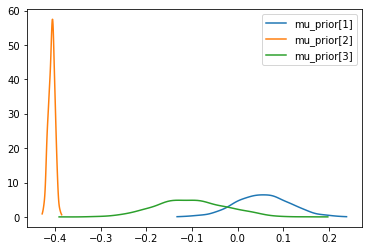

In [411]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

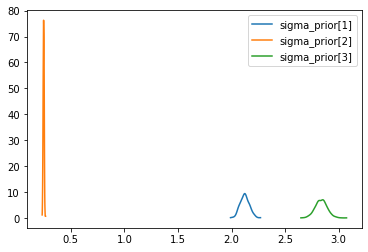

In [410]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

We can now use the inferred posteriors to make predictions. Lets first use the `pystan_utils` package to extract the expected values of the posterior distribution of the model parameters:

In [409]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per-individual, and adapt the code for making predictions accordingly. 

predictions: [2 2 2 ... 2 2 2]
true values: [2 2 2 ... 3 1 1]


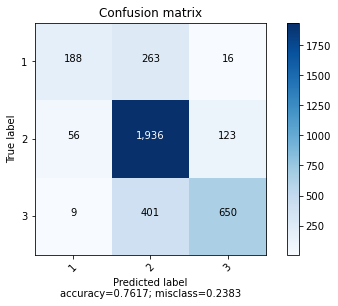

              precision    recall  f1-score   support

           1       0.74      0.40      0.52       467
           2       0.74      0.92      0.82      2115
           3       0.82      0.61      0.70      1060

    accuracy                           0.76      3642
   macro avg       0.77      0.64      0.68      3642
weighted avg       0.77      0.76      0.75      3642



In [408]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[1,2,3])
class_rep = classification_report(y_test, y_hat)
print(class_rep)

Given the posterior distributions inferred by STAN, we can even analyse the biases of different individuals identified by our model:

In [407]:
print(alpha.shape)
## the first 10 individuals
for i in range(10):
    print(i, alpha[:,i])

(3, 1192)
0 [ 1.28476506 -0.3707235  -1.78616501]
1 [-0.73226133 -0.33973266 -1.16843817]
2 [-0.84938072 -0.37817792 -1.33181059]
3 [-0.22865109 -0.41059015 -0.90068296]
4 [-0.57021049 -0.38382461 -2.79326545]
5 [-0.53972786 -0.40159098 -1.95998444]
6 [ 1.68951569 -0.40897662 -0.86055062]
7 [-0.8953285  -0.44135858  1.61706376]
8 [-0.63922197 -0.38852994 -2.18108625]
9 [ 0.61306289 -0.3970675  -0.86687781]


Perhaps a histogram allows for a better global analysis:

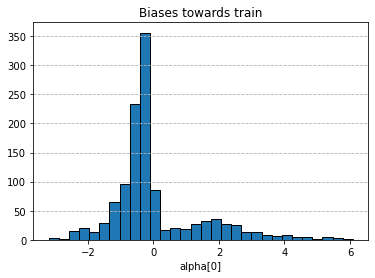

In [426]:
# histogram of biases towards Train: Mode 1
plt.hist(alpha[0,:],bins=30,edgecolor="k")
plt.title("Biases towards train")
plt.grid(linestyle = "--",axis="y")
plt.xlabel("alpha[0]")
plt.show()

We can observe that, for most individuals the biases is around 0. However, we can also see that a few individuals really love travelling with train!

#### With undersampling:

In [393]:
# prepare data for Stan model
N, D = X_rs.shape
C = int(y_rs.max())
I = int(ind_rs.max())
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_rs.astype(int), 'X': X_rs, 'y': y_rs}

N=3347, D=25, C=3, I=1192


In [394]:
%%time
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

Wall time: 3min 57s


In [395]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

predictions: [1 3 2 ... 3 2 1]
true values: [2 2 2 ... 3 1 1]


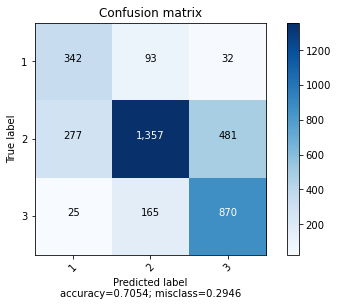

              precision    recall  f1-score   support

           1       0.53      0.73      0.62       467
           2       0.84      0.64      0.73      2115
           3       0.63      0.82      0.71      1060

    accuracy                           0.71      3642
   macro avg       0.67      0.73      0.69      3642
weighted avg       0.74      0.71      0.71      3642



In [396]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[1,2,3])
class_rep = classification_report(y_test, y_hat)
print(class_rep)

### Non-Bayesian inference

predictions: [2 2 2 ... 3 2 2]
true values: [2 2 2 ... 3 1 1]


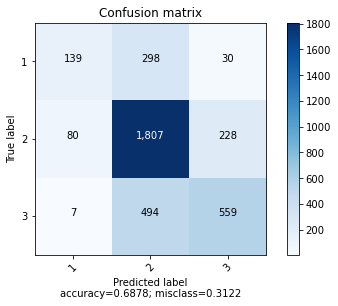

              precision    recall  f1-score   support

           1       0.62      0.30      0.40       467
           2       0.70      0.85      0.77      2115
           3       0.68      0.53      0.60      1060

    accuracy                           0.69      3642
   macro avg       0.66      0.56      0.59      3642
weighted avg       0.68      0.69      0.67      3642



In [386]:
# create and fit logistic regression model
logreg = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=2000)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
# print("Accuracy:", np.sum(y_hat == y_test) / len(y_test))
pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[1,2,3])
class_rep = classification_report(y_test, y_hat)
print(class_rep)